In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'graph_3'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
plot_folder = f'plots/{run}'

bs_merged_folder = f'../../data/training/baselines/merged/'

make_dir(plot_folder)
make_dir(merged_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

In [4]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)
metrics_df = metrics_df.reset_index(drop=True)
confusion_matrix_df = confusion_matrix_df.reset_index(drop=True)
synthethetic_df = synthethetic_df.reset_index(drop=True)
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
# confusion_matrix_df['shuffle_feature'] = confusion_matrix_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set', 'shuffle_feature', 'strategy']))

# baseline_df = pd.read_parquet(os.path.join(bs_merged_folder, 'metrics.parquet'))

print(labels)

['hidden_size', 'model', 'weight_decay']


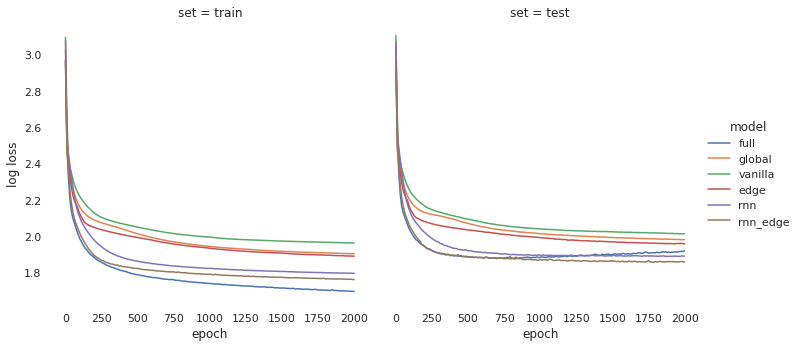

In [5]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
    'hidden_size': 5,
    'weight_decay': '1.e-4',
    'model': 'rnn_edge'
}

focus = ['model']#, 'hidden_size', 'weight_decay']

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)
fg.set(ylabel='log loss')

fg.savefig(os.path.join(plot_folder, 'architecture.jpg'))

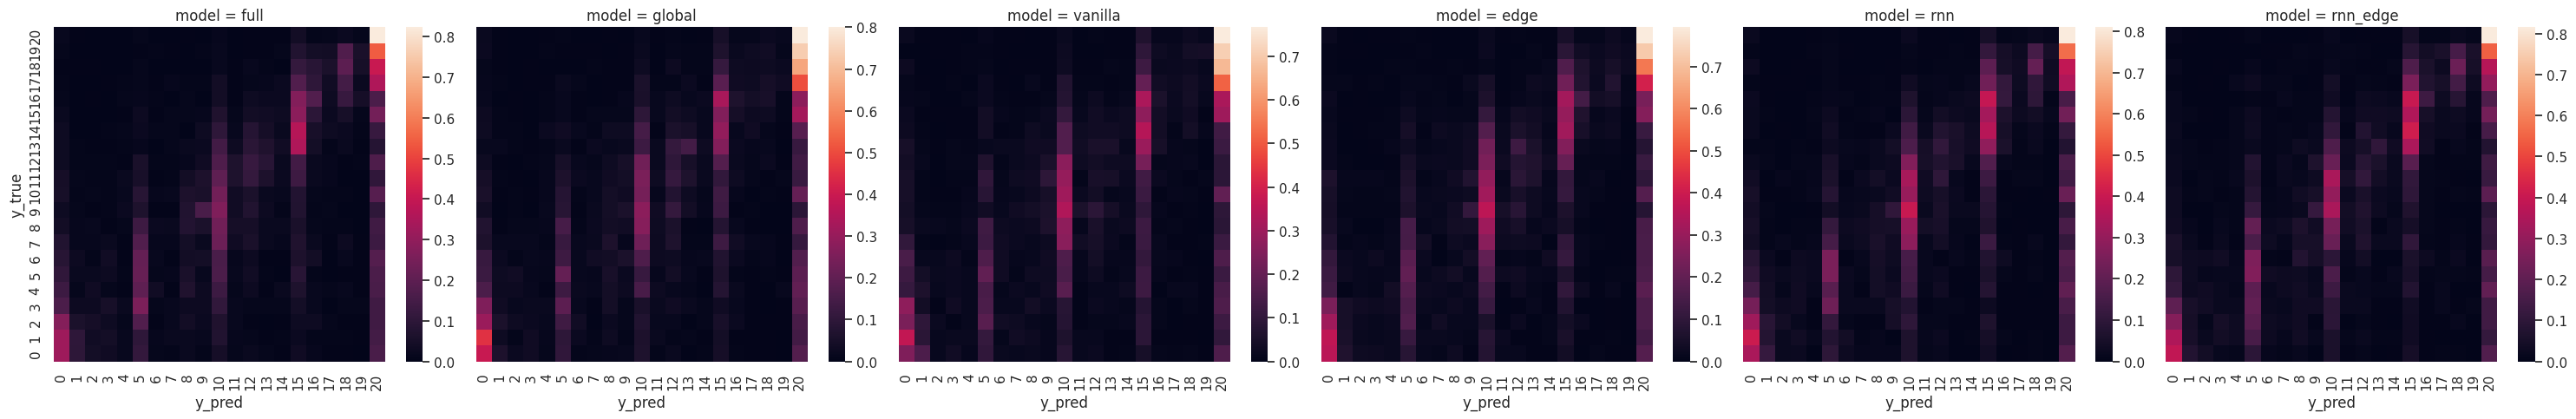

In [6]:
df = confusion_matrix_df.copy()

selection = {
    'hidden_size': 5,
    'weight_decay': '1.e-4',
    'model': 'rnn_edge'
}

focus_dimensions = ['model']#, 'hidden_size', 'weight_decay']

for f in focus_dimensions:
    if f in selection:
        selection.pop(f)

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

df = df[w]


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='y_true',y='y_pred', values='value')

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

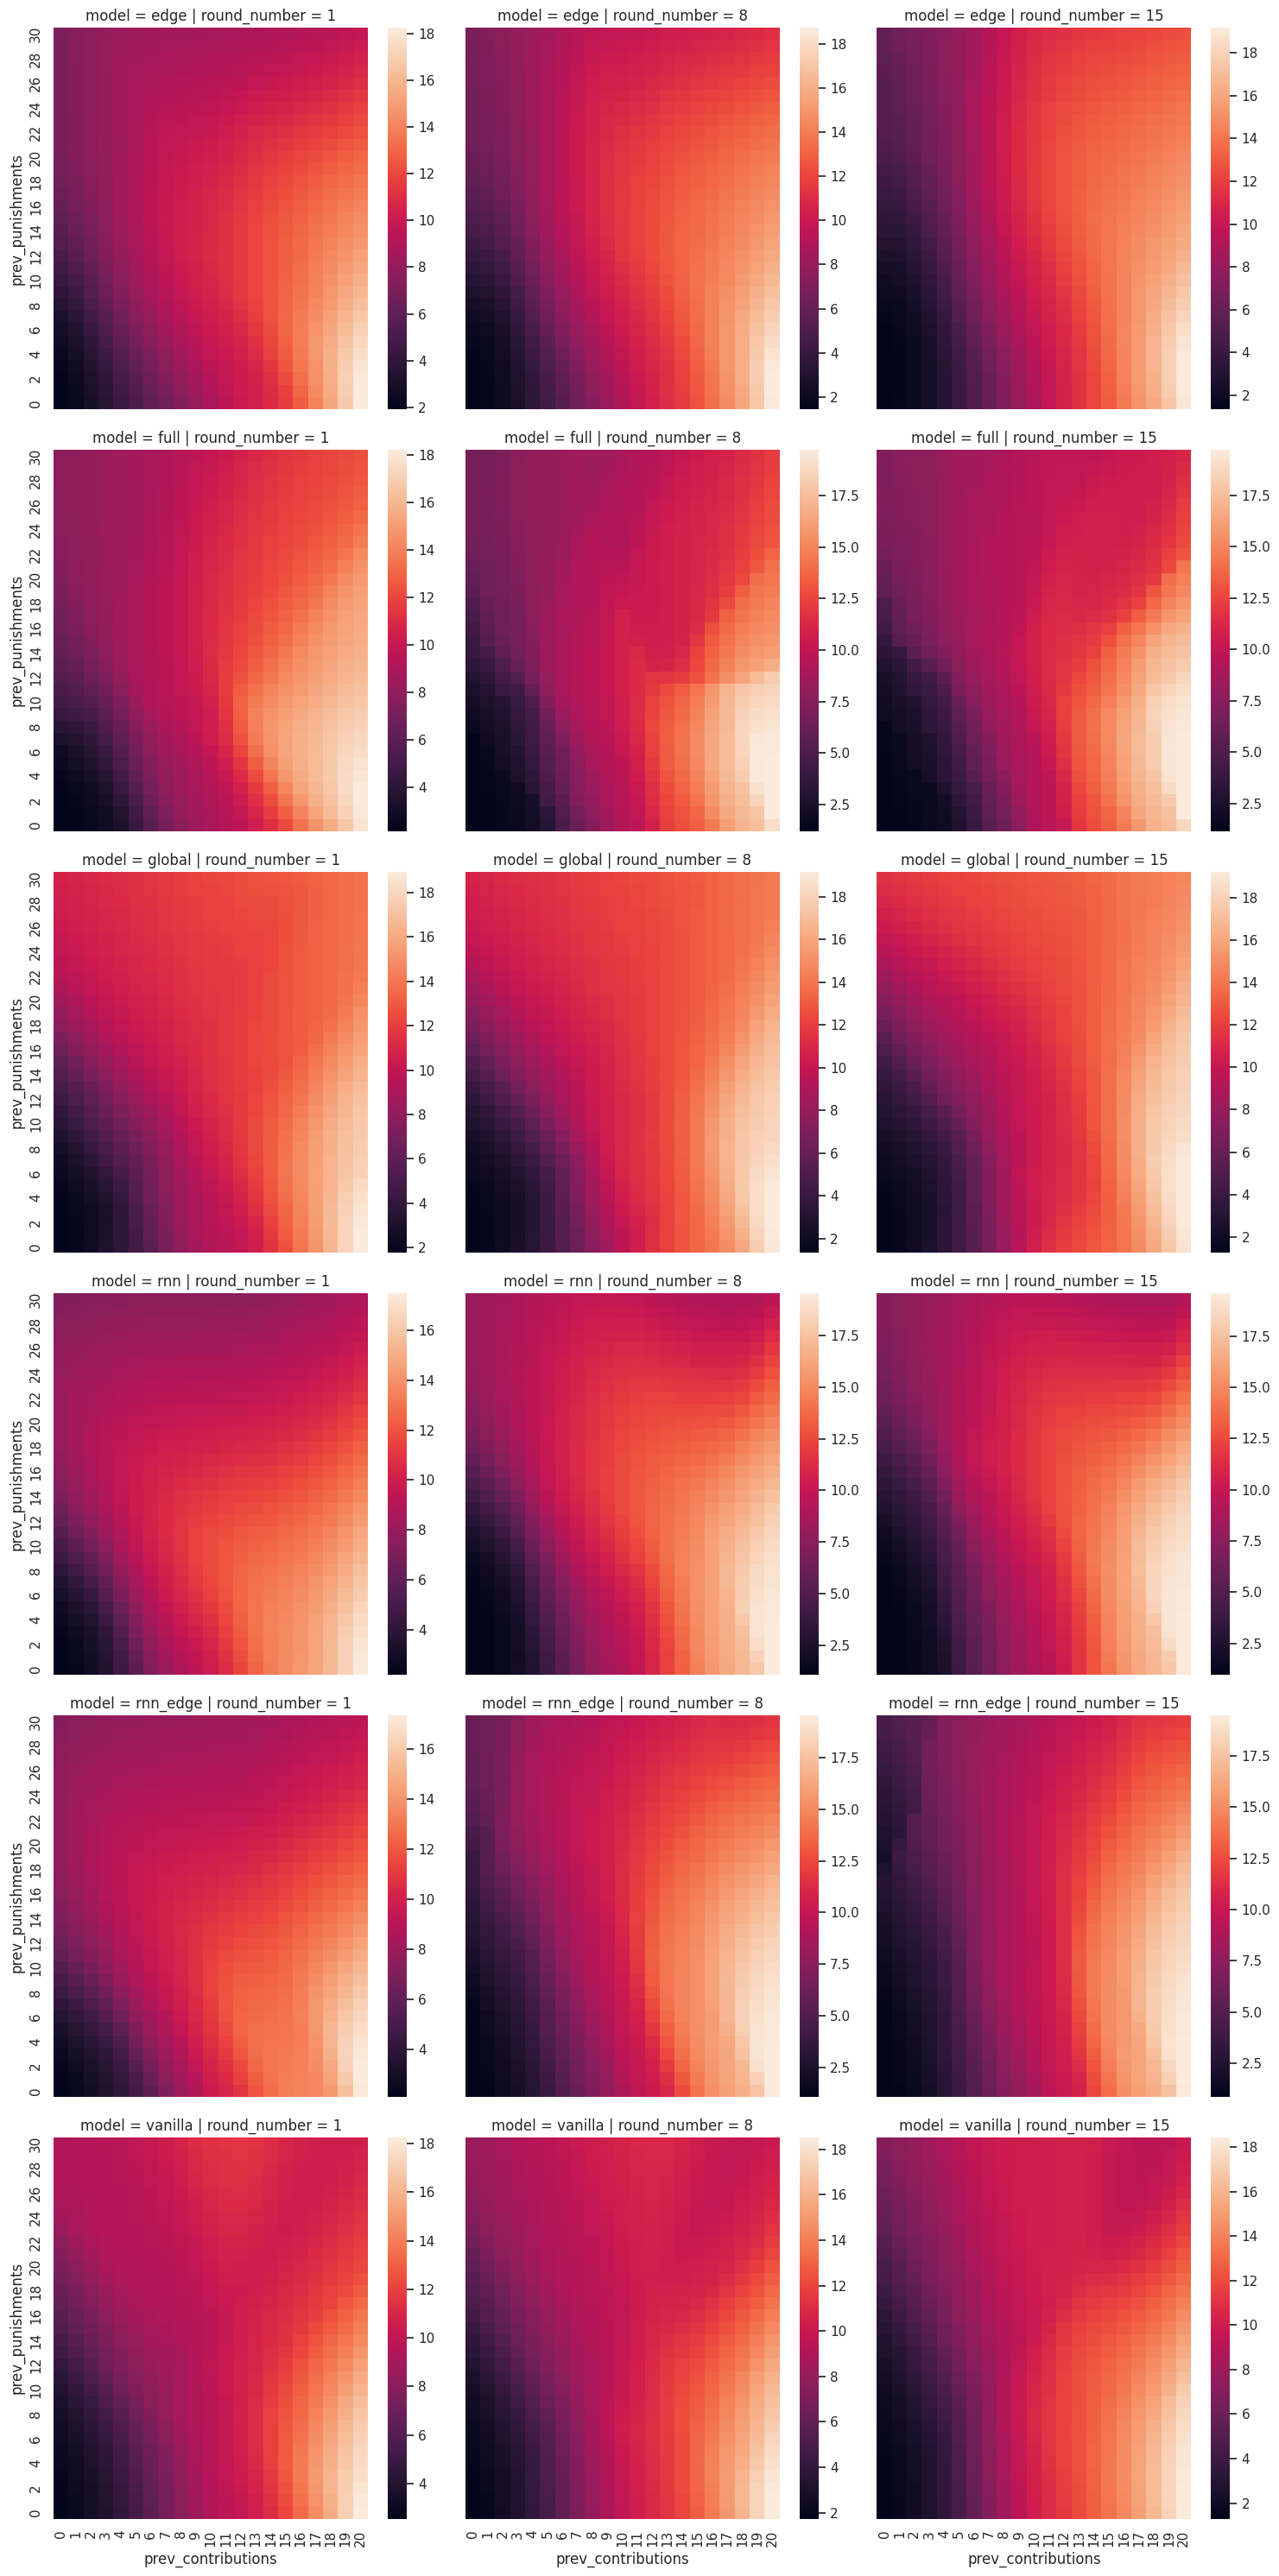

In [7]:
df = synthethetic_df.copy()

selection = {
    'hidden_size': 5,
    'weight_decay': '1.e-4',
    'model': 'rnn_edge',
    'round_number': [1,8,15]
}

focus_dimensions = ['round_number','model']#, 'hidden_size', 'weight_decay']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus_dimensions) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

df = df.groupby(focus_dimensions + ['prev_contributions', 'prev_punishments'])['exp_contribution'].mean().reset_index(drop=False)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_punishments',y='prev_contributions', values='exp_contribution', normalise=False)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    col_wrap=5 if len(focus_dimensions) < 2 else None,
    height=5)
fg.map_dataframe(plot_heatmap)